In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import telegram
import pandahouse
from datetime import date
import io
from read_db.CH import Getch
import sys
import os

In [2]:
chat_id = 187545653
bot = telegram.Bot(token='***')

# LET'S START

In [ ]:
data = Getch(''' SELECT
    fa.ts,
    fa.date,
    fa.hm_15min,
    fa.user_feed_cnt,
    fa.view_cnt,
    fa.like_cnt,
    ma.message_cnt
FROM ( 
    select toStartOfFifteenMinutes(time) as ts 
    , toDate(ts) as date
    , formatDateTime(ts, '%R') as hm_15min
    , uniqExact(user_id) as user_feed_cnt
    , countIf(user_id, action='view') as view_cnt
    , countIf(user_id, action='like') as like_cnt
from simulator_20211220.feed_actions
WHERE ts >=  today() - 30 and ts < today()
GROUP BY ts, date, hm_15min
ORDER BY ts) as fa
left join (
    select 
    toStartOfFifteenMinutes(time) as ts 
    , toDate(ts) as date
    , formatDateTime(ts, '%R') as hm_15min
    , count(user_id) as message_cnt
FROM simulator_20211220.message_actions
WHERE ts >=  today() - 30 and ts < today()
GROUP BY ts, date, hm_15min
ORDER BY ts
) as ma
on ma.date=fa.date and ma.hm_15min=fa.hm_15min
ORDER BY ts ''').df

# df = Getch(''' SELECT
#     toStartOfHour(time) as ts
#     , toUInt64(time) as ts_int
#     , formatDateTime(ts, '%R') as hm
#     , toDayOfWeek(time) as weekday
#     , uniqExact(user_id) as users_lenta
# FROM simulator.feed_actions
# WHERE ts >=  today() - 30 and ts < toStartOfFifteenMinutes(now())
# GROUP BY ts, ts_int, hm, weekday
# ORDER BY ts ''').df

# , toStartOfMinute(time) as ts_min
# , formatDateTime(ts_min, '%R') as hm_min

# toStartOfFifteenMinutes(time) as ts

metrics = ['user_feed_cnt', 'view_cnt', 'like_cnt', 'message_cnt']
data

,ts,date,hm_15min,user_feed_cnt,view_cnt,like_cnt,message_cnt
0,2021-12-27 00:00:00,2021-12-27,00:00,371,5424,1105,81
1,2021-12-27 00:15:00,2021-12-27,00:15,348,5224,1031,92
2,2021-12-27 00:30:00,2021-12-27,00:30,324,4831,1050,71
3,2021-12-27 00:45:00,2021-12-27,00:45,323,4643,985,69
4,2021-12-27 01:00:00,2021-12-27,01:00,310,4666,963,68
...,...,...,...,...,...,...,...
2875,2022-01-25 22:45:00,2022-01-25,22:45,520,8999,2009,111
2876,2022-01-25 23:00:00,2022-01-25,23:00,498,8799,1833,77
2877,2022-01-25 23:15:00,2022-01-25,23:15,469,8121,1711,64
2878,2022-01-25 23:30:00,2022-01-25,23:30,472,8654,1897,82


In [4]:
df = data.copy()

## Remove outliers by 1.5*IQR

In [28]:
dict_15mins = {}
for i in range(len(df)):
    if df['hm_15min'][i] in dict_15mins.keys():
        dict_15mins[df['hm_15min'][i]].append(df['user_feed_cnt'].values[i])
    else:
        dict_15mins[df['hm_15min'][i]]=[df['user_feed_cnt'][i]] 
df_15mins = pd.DataFrame.from_dict(dict_15mins)
df_15mins.head()

,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,02:00,02:15,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,937,682,430,415,357,369,355,324,304,292,...,661,621,603,586,565,549,542,499,480,468
1,462,462,446,423,380,354,358,335,333,301,...,646,600,587,571,549,528,526,519,515,475
2,440,443,435,390,391,358,326,324,285,290,...,643,645,589,582,587,527,525,519,479,457
3,463,446,406,368,380,339,331,329,288,280,...,647,610,594,593,544,550,545,513,489,461
4,438,439,424,376,372,347,327,317,320,296,...,635,614,590,575,543,542,516,502,496,467


In [7]:
# find outlier in every hm group, remove them
# create dict with hm and array of values
dict_means_15mins = {}
for hm_15min in df_15mins.columns:
    hm_15min_values_list = df_15mins[hm_15min].values.tolist()
    # print(df_15mins[hm_15min])
    iqr = pd.Series(df_15mins[hm_15min]).quantile(0.75)-pd.Series(df_15mins[hm_15min]).quantile(0.25)
    for i in range(len(df_15mins)):
        if df_15mins[hm_15min][i]<pd.Series(df_15mins[hm_15min]).quantile(0.25)-1.5*iqr \
            or df_15mins[hm_15min][i]>pd.Series(df_15mins[hm_15min]).quantile(0.75)+1.5*iqr:
                # print(hm_15min)
                # print('lower = ',pd.Series(df_15mins[hm_15min]).quantile(0.25)-1.5*iqr)
                # print('upper = ',pd.Series(df_15mins[hm_15min]).quantile(0.75)+1.5*iqr)
                # print('ALEEEEERT - ', df_15mins[hm_15min][i])
                hm_15min_values_list.remove(df_15mins[hm_15min][i])
    dict_means_15mins[hm_15min] = [round(np.mean(hm_15min_values_list),2), np.median(hm_15min_values_list),
                                  round(np.std(hm_15min_values_list),2), len(hm_15min_values_list)]
    
# dict_means_15mins

### Confidence interval low and up

In [8]:
df_means_15mins = pd.DataFrame.from_dict(dict_means_15mins)
df_means_15mins = df_means_15mins.transpose().reset_index()
df_means_15mins.columns = ['hm_15min', 'mean', 'median', 'std', 'n']
df_means_15mins['se'] = round(df_means_15mins['std']/(df_means_15mins['n']**(1/2)),2)
df_means_15mins['ci_low_95'] = round(df_means_15mins['mean'] - df_means_15mins['se']*1.96,2)
df_means_15mins['ci_up_95'] = round(df_means_15mins['mean'] + df_means_15mins['se']*1.96,2)
df_means_15mins['sigma_low'] = round(df_means_15mins['mean'] - df_means_15mins['std']*3,2)
df_means_15mins['sigma_up'] = round(df_means_15mins['mean'] + df_means_15mins['std']*3,2)
df_means_15mins

,hm_15min,mean,median,std,n,se,ci_low_95,ci_up_95,sigma_low,sigma_up
0,00:00,427.86,431.0,20.86,29.0,3.87,420.27,435.45,365.28,490.44
1,00:15,412.41,410.0,21.71,29.0,4.03,404.51,420.31,347.28,477.54
2,00:30,398.03,393.0,20.54,29.0,3.81,390.56,405.50,336.41,459.65
3,00:45,376.79,376.0,16.67,28.0,3.15,370.62,382.96,326.78,426.80
4,01:00,360.13,364.5,16.76,30.0,3.06,354.13,366.13,309.85,410.41
...,...,...,...,...,...,...,...,...,...,...
91,22:45,517.76,513.0,16.94,29.0,3.15,511.59,523.93,466.94,568.58
92,23:00,502.23,502.5,23.69,30.0,4.33,493.74,510.72,431.16,573.30
93,23:15,484.57,481.0,19.79,30.0,3.61,477.49,491.65,425.20,543.94
94,23:30,465.83,465.0,18.54,29.0,3.44,459.09,472.57,410.21,521.45


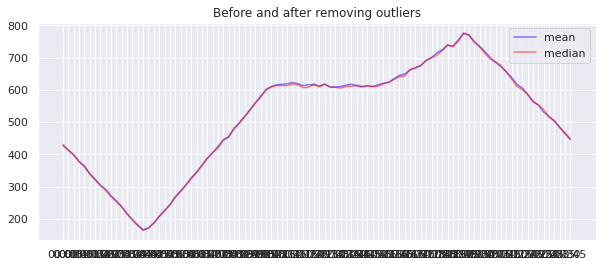

In [89]:
# comparing mean and median
fig = plt.figure(figsize=(10, 4))
plt.title('Before and after removing outliers')
plt.plot(df_means_15mins['hm_15min'], df_means_15mins['mean'], color='blue', alpha=.5, label='mean')
plt.plot(df_means_15mins['hm_15min'], df_means_15mins['median'], color='red', alpha=.5, label='median')

plt.legend()
# [df['date']=='2022-01-09']
plt.show()

[(0.0, 909.8915000000001)]

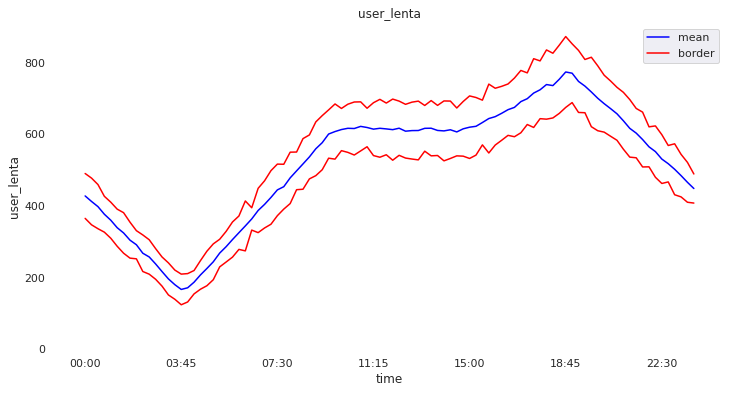

In [10]:
sns.set(rc={'figure.figsize': (12, 6)}) 
plt.tight_layout()

ax = sns.lineplot( 
    x=df_means_15mins['hm_15min'], 
    y=df_means_15mins['mean'],
    color='blue',
    label='mean'
    )

ax = sns.lineplot( 
    x=df_means_15mins['hm_15min'], 
    # y=df_means_15mins['ci_low']
    y=df_means_15mins['sigma_low'],
    color='red',
    label='border'
    )

ax = sns.lineplot(
    x=df_means_15mins['hm_15min'], 
    # y=df_means_15mins['ci_up']
    y=df_means_15mins['sigma_up'],
    color='red'
    )


for ind, label in enumerate(ax.get_xticklabels()): 
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
ax.set(xlabel='time')
ax.set(ylabel='user_lenta') 
ax.grid(True)
ax.set_facecolor('white')


ax.set_title('{}'.format('user_lenta')) 
ax.set(ylim=(0, None))

### Get today data

In [ ]:
data_today = Getch(''' SELECT
    fa.ts,
    fa.date,
    fa.hm_15min,
    fa.user_feed_cnt,
    fa.view_cnt,
    fa.like_cnt,
    ma.message_cnt
FROM ( 
    select toStartOfFifteenMinutes(time) as ts 
    , toDate(ts) as date
    , formatDateTime(ts, '%R') as hm_15min
    , uniqExact(user_id) as user_feed_cnt
    , countIf(user_id, action='view') as view_cnt
    , countIf(user_id, action='like') as like_cnt
from simulator_20211220.feed_actions
WHERE ts >= today() and ts < toStartOfFifteenMinutes(now())
GROUP BY ts, date, hm_15min
ORDER BY ts) as fa
left join (
    select 
    toStartOfFifteenMinutes(time) as ts 
    , toDate(ts) as date
    , formatDateTime(ts, '%R') as hm_15min
    , count(user_id) as message_cnt
FROM simulator_20211220.message_actions
WHERE ts >= today() and ts < toStartOfFifteenMinutes(now())
GROUP BY ts, date, hm_15min
ORDER BY ts
) as ma
on ma.date=fa.date and ma.hm_15min=fa.hm_15min
ORDER BY ts ''').df

In [ ]:
df_today = data_today.copy()
hm_max_today_idx = len(df_today)-1
df_today.sample(10)

,ts,date,hm_15min,user_feed_cnt,view_cnt,like_cnt
0,2022-01-21 00:00:00,2022-01-21,00:00,436,7783,1944
1,2022-01-21 00:15:00,2022-01-21,00:15,431,7725,1860
2,2022-01-21 00:30:00,2022-01-21,00:30,412,7939,1913
3,2022-01-21 00:45:00,2022-01-21,00:45,365,6591,1665
4,2022-01-21 01:00:00,2022-01-21,01:00,359,6455,1513
5,2022-01-21 01:15:00,2022-01-21,01:15,363,6774,1631
6,2022-01-21 01:30:00,2022-01-21,01:30,336,6155,1432
7,2022-01-21 01:45:00,2022-01-21,01:45,324,5902,1372
8,2022-01-21 02:00:00,2022-01-21,02:00,283,4950,1202
9,2022-01-21 02:15:00,2022-01-21,02:15,274,4705,1212


In [35]:
df_all = df_means_15mins.merge(data_today, how='left', on='hm_15min').drop(columns=['ts','date'])
df_all

,hm_15min,mean,median,std,n,se,ci_low_95,ci_up_95,sigma_low,sigma_up,user_feed_cnt,view_cnt,like_cnt,message_cnt
0,00:00,427.86,431.0,20.86,29.0,3.87,420.27,435.45,365.28,490.44,447.0,7518.0,1653.0,72.0
1,00:15,412.41,410.0,21.71,29.0,4.03,404.51,420.31,347.28,477.54,409.0,6853.0,1496.0,80.0
2,00:30,398.03,393.0,20.54,29.0,3.81,390.56,405.50,336.41,459.65,367.0,6086.0,1340.0,79.0
3,00:45,376.79,376.0,16.67,28.0,3.15,370.62,382.96,326.78,426.80,359.0,5850.0,1277.0,79.0
4,01:00,360.13,364.5,16.76,30.0,3.06,354.13,366.13,309.85,410.41,334.0,5426.0,1100.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,22:45,517.76,513.0,16.94,29.0,3.15,511.59,523.93,466.94,568.58,NaN,NaN,NaN,NaN
92,23:00,502.23,502.5,23.69,30.0,4.33,493.74,510.72,431.16,573.30,NaN,NaN,NaN,NaN
93,23:15,484.57,481.0,19.79,30.0,3.61,477.49,491.65,425.20,543.94,NaN,NaN,NaN,NaN
94,23:30,465.83,465.0,18.54,29.0,3.44,459.09,472.57,410.21,521.45,NaN,NaN,NaN,NaN


[(0.0, 909.8915000000001)]

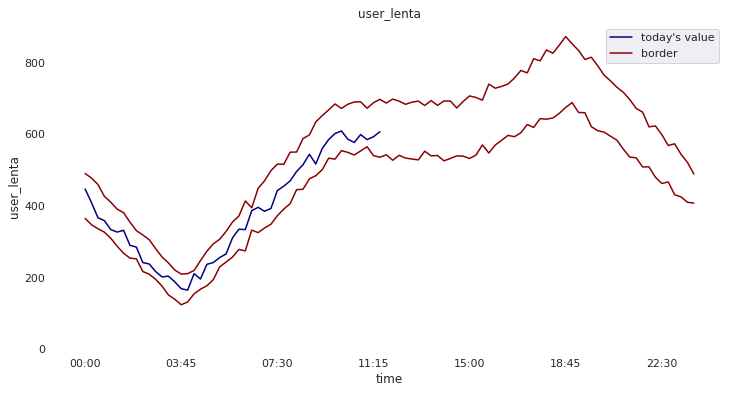

In [16]:
sns.set(rc={'figure.figsize': (12, 6)}) 
plt.tight_layout()

ax = sns.lineplot( 
    x=df_all['hm_15min'], 
    y=df_all['users_lenta'],
    color='navy',
    label="today's value"
    )

ax = sns.lineplot( 
    x=df_all['hm_15min'], 
    y=df_all['sigma_low'],
    color='darkred',
    label='border'
    )

ax = sns.lineplot(
    x=df_all['hm_15min'], 
    y=df_all['sigma_up'],
    color='darkred'
    )


for ind, label in enumerate(ax.get_xticklabels()): 
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
ax.set(xlabel='time')
ax.set(ylabel='user_lenta') 
ax.grid(True)
ax.set_facecolor('white')


ax.set_title('{}'.format('user_lenta')) 
ax.set(ylim=(0, None))

In [150]:
if df_all['users_lenta'][hm_max_today_idx]<df_all['sigma_low'][hm_max_today_idx] or \
        df_all['users_lenta'][hm_max_today_idx]>df_all['sigma_up'][hm_max_today_idx]:
    is_alert = True
else:
    is_alert = False

## LET'S CREATE FUNCTIONS

In [1]:
def check_anomaly(df, df_today, metric):
    hm_max_today_idx = len(df_today)-1
    dict_15mins = {}
    for i in range(len(df)):
        if df['hm_15min'][i] in dict_15mins.keys():
            dict_15mins[df['hm_15min'][i]].append(df[metric].values[i])
        else:
            dict_15mins[df['hm_15min'][i]]=[df[metric][i]] 
    df_15mins = pd.DataFrame.from_dict(dict_15mins)
    
    dict_means_15mins = {}
    for hm_15min in df_15mins.columns:
        hm_15min_values_list = df_15mins[hm_15min].values.tolist()
        # print(df_15mins[hm_15min])
        iqr = pd.Series(df_15mins[hm_15min]).quantile(0.75)-pd.Series(df_15mins[hm_15min]).quantile(0.25)
        for i in range(len(df_15mins)):
            if df_15mins[hm_15min][i]<pd.Series(df_15mins[hm_15min]).quantile(0.25)-1.5*iqr \
                or df_15mins[hm_15min][i]>pd.Series(df_15mins[hm_15min]).quantile(0.75)+1.5*iqr:
                    # print(hm_15min)
                    # print('lower = ',pd.Series(df_15mins[hm_15min]).quantile(0.25)-1.5*iqr)
                    # print('upper = ',pd.Series(df_15mins[hm_15min]).quantile(0.75)+1.5*iqr)
                    # print('ALEEEEERT - ', df_15mins[hm_15min][i])
                    hm_15min_values_list.remove(df_15mins[hm_15min][i])
        dict_means_15mins[hm_15min] = [round(np.mean(hm_15min_values_list),2), np.median(hm_15min_values_list),
                                      round(np.std(hm_15min_values_list),2), len(hm_15min_values_list)]
    
    df_means_15mins = pd.DataFrame.from_dict(dict_means_15mins)
    df_means_15mins = df_means_15mins.transpose().reset_index()
    df_means_15mins.columns = ['hm_15min', 'mean', 'median', 'std', 'n']
    df_means_15mins['se'] = round(df_means_15mins['std']/(df_means_15mins['n']**(1/2)),2)
    df_means_15mins['ci_low_95'] = round(df_means_15mins['mean'] - df_means_15mins['se']*1.96,2)
    df_means_15mins['ci_up_95'] = round(df_means_15mins['mean'] + df_means_15mins['se']*1.96,2)
    df_means_15mins['sigma_low'] = round(df_means_15mins['mean'] - df_means_15mins['std']*3,2)
    df_means_15mins['sigma_up'] = round(df_means_15mins['mean'] + df_means_15mins['std']*3,2)
    
    df_all = df_means_15mins.merge(df_today, how='left', on='hm_15min').drop(columns=['ts','date'])
    
    # проверяем больше ли отклонение метрики заданного порога threshold
    # если отклонение больше, то вернем 1, в противном случае 0
    
    current_value = df_all[metric][hm_max_today_idx]
    pred_value = df_all['mean'][hm_max_today_idx]
    # diff = round(current_value / pred_value - 1,2)
    
    # if current_value<df_all['sigma_low'][hm_max_today_idx] or current_value>df_all['sigma_up'][hm_max_today_idx]:
    #     is_alert = 1
    # else:
    #     is_alert = 0
        
    if current_value<df_all['sigma_low'][hm_max_today_idx]:
        diff = round(current_value / df_all['sigma_low'][hm_max_today_idx] - 1,2)
        is_alert = 1
    elif current_value>df_all['sigma_up'][hm_max_today_idx]:
        diff = round(current_value / df_all['sigma_up'][hm_max_today_idx] - 1,2)
        is_alert = 1
    else:
        diff = round(current_value / df_all['mean'][hm_max_today_idx] - 1,2)
        is_alert = 0


    return is_alert, current_value, diff, df_all
    # print(is_alert, current_value, diff)

In [21]:
def run_alerts(chat=None):
    chat_id = chat or 187545653
    bot = telegram.Bot(token='5029891106:AAFyzHPo3PufBPunqVTs6OxNzuW8xc08dK0')

    # для удобства построения графиков в запрос можно добавить колонки date, hm
    data = Getch(''' SELECT
        fa.ts,
        fa.date,
        fa.hm_15min,
        fa.user_feed_cnt,
        fa.view_cnt,
        fa.like_cnt,
        ma.message_cnt
    FROM ( 
        select toStartOfFifteenMinutes(time) as ts 
        , toDate(ts) as date
        , formatDateTime(ts, '%R') as hm_15min
        , uniqExact(user_id) as user_feed_cnt
        , countIf(user_id, action='view') as view_cnt
        , countIf(user_id, action='like') as like_cnt
    from simulator.feed_actions
    WHERE ts >=  today() - 30 and ts < today()
    GROUP BY ts, date, hm_15min
    ORDER BY ts) as fa
    left join (
        select 
        toStartOfFifteenMinutes(time) as ts 
        , toDate(ts) as date
        , formatDateTime(ts, '%R') as hm_15min
        , count(user_id) as message_cnt
    FROM simulator.message_actions
    WHERE ts >=  today() - 30 and ts < today()
    GROUP BY ts, date, hm_15min
    ORDER BY ts
    ) as ma
    on ma.date=fa.date and ma.hm_15min=fa.hm_15min
    ORDER BY ts ''').df
    
    data_today = Getch(''' SELECT
        fa.ts,
        fa.date,
        fa.hm_15min,
        fa.user_feed_cnt,
        fa.view_cnt,
        fa.like_cnt,
        ma.message_cnt
    FROM ( 
        select toStartOfFifteenMinutes(time) as ts 
        , toDate(ts) as date
        , formatDateTime(ts, '%R') as hm_15min
        , uniqExact(user_id) as user_feed_cnt
        , countIf(user_id, action='view') as view_cnt
        , countIf(user_id, action='like') as like_cnt
    from simulator.feed_actions
    WHERE ts >= today() and ts < toStartOfFifteenMinutes(now())
    GROUP BY ts, date, hm_15min
    ORDER BY ts) as fa
    left join (
        select 
        toStartOfFifteenMinutes(time) as ts 
        , toDate(ts) as date
        , formatDateTime(ts, '%R') as hm_15min
        , count(user_id) as message_cnt
    FROM simulator.message_actions
    WHERE ts >= today() and ts < toStartOfFifteenMinutes(now())
    GROUP BY ts, date, hm_15min
    ORDER BY ts
    ) as ma
    on ma.date=fa.date and ma.hm_15min=fa.hm_15min
    ORDER BY ts ''').df
    

    metrics = {'user_feed_cnt':'Users', 'view_cnt':'Views', 'like_cnt':'Likes', 'message_cnt':'Messages'}
    for metric, metric_nm in metrics.items():
        is_alert, current_value, diff, df_all = check_anomaly(data, data_today, metric)
        # print(metric)
        # print(metric_nm)
        # print(is_alert)
        # print(current_value)
        # print(diff)
    
    # metrics = {'user_feed_cnt':'Users', 'view_cnt':'Views', 'like_cnt':'Likes', 'message_cnt':'Messages'}
    # for metric, metric_nm in metrics.items():
    #     is_alert, current_value, diff, df_all = check_anomaly(data, data_today, metric)
    #     print(is_alert, current_value, diff, df_all)
        if is_alert==0 and abs(diff)>0.1:
            msg = '''❗️❗️❗️<b>ALARM</b>❗️❗️❗️ \nMetric - <b>{metric}</b>:\nCurrent value = <b>{current_value}</b>\nDeviation = <b>{diff:.2%}</b>'''.format(metric=metric_nm,
                                                                                                             current_value=current_value,
                                                                                                             diff=diff)

            sns.set(rc={'figure.figsize': (12, 6)}) 
            plt.tight_layout()

            ax = sns.lineplot( 
                x=df_all['hm_15min'], y=df_all[metric], color='navy', label="current value"
                )

            ax = sns.lineplot( 
                x=df_all['hm_15min'], y=df_all['sigma_low'], color='darkred', label='border'
                )

            ax = sns.lineplot(
                x=df_all['hm_15min'], y=df_all['sigma_up'], color='darkred'
                )


            for ind, label in enumerate(ax.get_xticklabels()): 
                if ind % 15 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)

            ax.set(xlabel='time')
            ax.set(ylabel=metric_nm) 
            ax.grid(True)
            ax.set_facecolor('white')
            ax.legend(edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 0.1))

            ax.set_title('{}'.format(metric_nm)) 
            ax.set(ylim=(0, None))
            
            # формируем файловый объект
            plot_object = io.BytesIO()
            ax.figure.savefig(plot_object)
            plot_object.seek(0)
            plot_object.name = '{0}.png'.format(metric_nm)
            # plt.show()
            plt.close()
            

            # отправляем алерт
            bot.sendMessage(chat_id=chat_id, text=msg, parse_mode=telegram.ParseMode.HTML)
            bot.sendPhoto(chat_id=chat_id, photo=plot_object)

In [22]:
try:
    run_alerts()
except Exception as e:
    print(e)

In [23]:
metrics = {'user_feed_cnt':'Users', 'view_cnt':'Views', 'like_cnt':'Likes', 'message_cnt':'Messages'}
for metric, metric_nm in metrics.items():
    is_alert, current_value, diff, df_all = check_anomaly(data, data_today, metric)
    print(diff)

0.01
0.16
0.19
-0.05


#### Removing outliers by days

init date -  2021-12-16T00:00:00.000000000


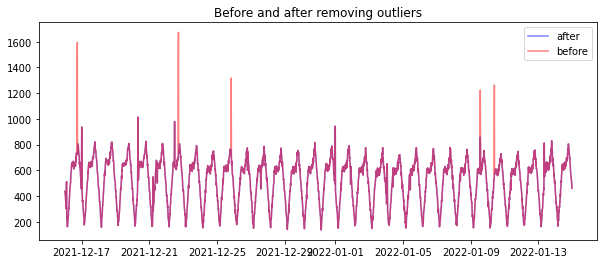

In [78]:
date = df['date'].values[0]
# print('init date - ', date)
outliers_idxs = []
i = 0
flag=False

while i < len(df):
    array_15min = []
    array_15min_idx = []
    while df['date'].values[i]==date:
        array_15min.append(df['users_lenta'].values[i])
        array_15min_idx.append(i)
        if i==len(df)-1:
            break
        else:
            i+=1
    dict_15min = dict(zip(array_15min_idx, array_15min))
    iqr = pd.Series(dict_15min.values()).quantile(0.75)-pd.Series(dict_15min.values()).quantile(0.25)
    for idx in dict_15min.keys():
        if dict_15min[idx]<pd.Series(dict_15min).quantile(0.25)-1.5*iqr \
            or dict_15min[idx]>pd.Series(dict_15min).quantile(0.75)+1.5*iqr:
            # print(df['ts'].values[idx])
            # print('lower = ',pd.Series(dict_15min).quantile(0.25)-1.5*iqr)
            # print('upper = ',pd.Series(dict_15min).quantile(0.75)+1.5*iqr)
            # print('ALEEEEERT - ', dict_15min[idx])
            outliers_idxs.append(idx)
    date = df['date'].values[i]
    if i==len(df)-1:
        break
    i+=1

# print(len(df), len(outliers_idxs))

df_wo_outliers = df.drop(index=outliers_idxs)
df_wo_outliers.shape

fig = plt.figure(figsize=(10, 4))
plt.title('Before and after removing outliers')
plt.plot(df_wo_outliers['ts'], df_wo_outliers['users_lenta'], color='blue', alpha=.5, label='after')
plt.plot(df['ts'], df['users_lenta'], color='red', alpha=.5, label='before')

plt.legend()
# [df['date']=='2022-01-09']
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


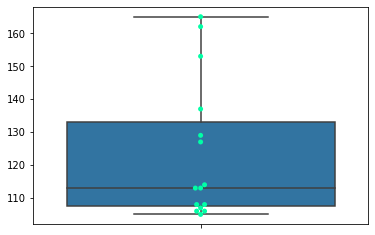

In [ ]:
ax = sns.boxplot(y=df['users_lenta'][45:60].values)
ax = sns.swarmplot(y=df['users_lenta'][45:60].values, color="#00ffa6")
print(ax)